# Практическое занятие №2

## Фильтрация изображений

Подключаем необходимые либы

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

Прежде, чем фильтровать изображение посмотрим еще один тип шума: высокочастотный

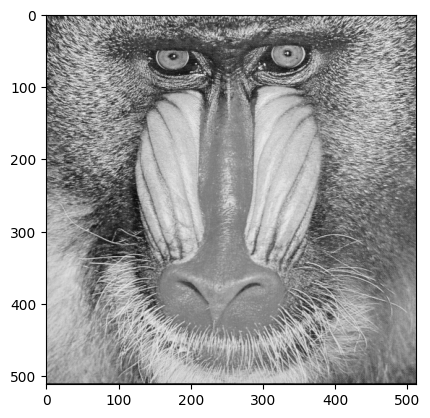

In [4]:
fileName = 'Mandrill.png'
img = cv2.imread(fileName)
if len(img.shape) > 2:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.imshow(img, cmap='gray')

Генерируем шум

In [5]:
M, N = img.shape

In [68]:
# Генерируем случайную частоту
f = np.random.randint(1, 5000)
# Выбираем случайную частоту дискретизации (> 2*f)
fs = np.random.randint(2, 10) * f
# Считаем период дискретизации
ts = 1/fs
t = np.arange(0, M*N, 1)
# Дискретизируем сигнал
T = np.array(t) * ts

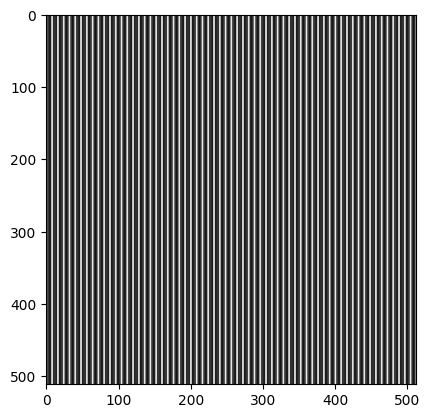

In [69]:
# Получаем зашумленный сигнал
dirty_cos = np.cos(2 * np.pi * f * T) * 255
# Перегоняем его в размер изображения
dirty_cos = np.reshape(dirty_cos, (M, N)).astype('uint8')

plt.imshow(dirty_cos, cmap='gray')

Добавим полученный шум к изображению

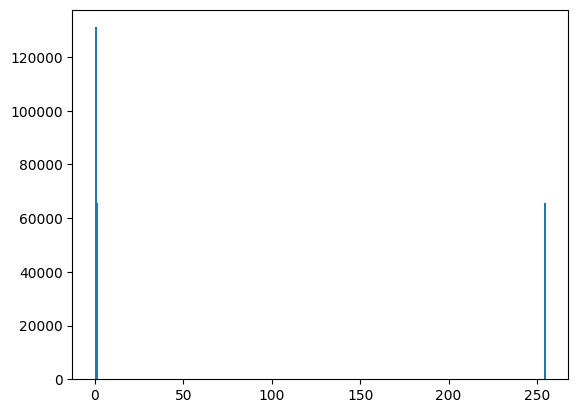

In [43]:
plt.hist(dirty_cos.ravel(), bins=256)
plt.show()

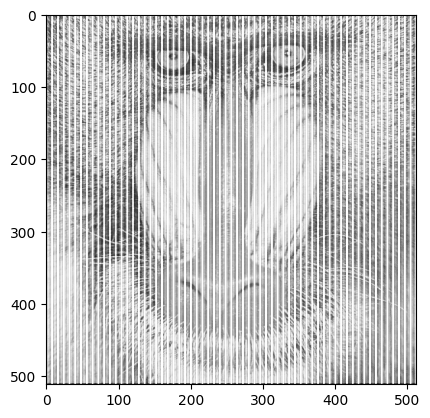

In [70]:
hf_img = cv2.add(img, dirty_cos)
plt.imshow(hf_img, cmap='gray')

Теперь переходим к фильтрации изображений

Сначала попробуем отфильтровать импульсный шум

Для этого будем использовать скользящую медиану

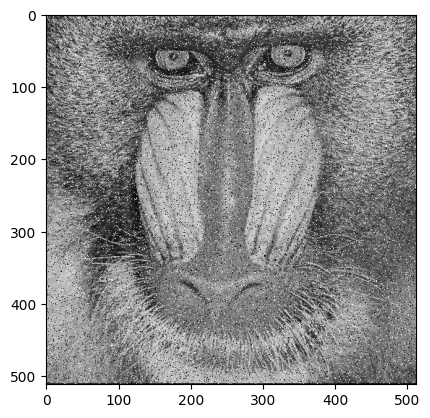

In [54]:
fileName = 'Noisy_Mandrill.png'
impulse_img = cv2.imread(fileName)
if len(impulse_img.shape) > 2:
    impulse_img = cv2.cvtColor(impulse_img, cv2.COLOR_BGR2GRAY)
    
plt.imshow(impulse_img, cmap='gray')

Попробуем отфильтровать наш ВЧ-шум при помощи скользящего среднего

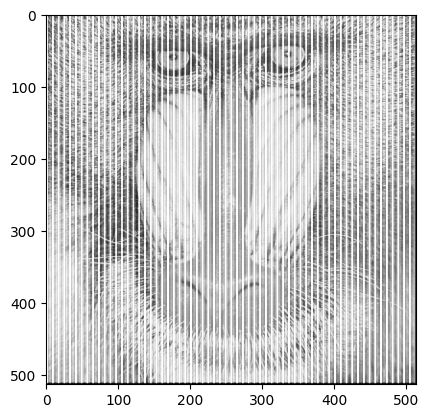

In [71]:
impulse_img2 = cv2.copyMakeBorder(hf_img, 1, 1, 1, 1, cv2.BORDER_CONSTANT, value=0)
plt.imshow(impulse_img2, cmap='gray')

In [72]:
M2, N2 = impulse_img2.shape
(M2, N2)

(514, 514)

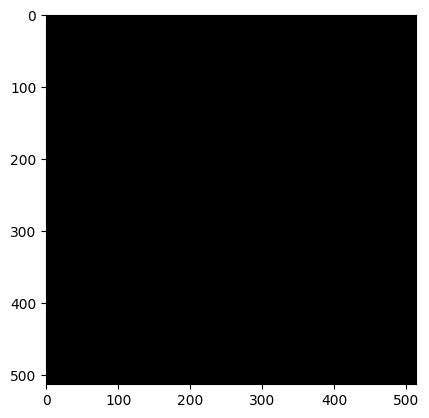

In [73]:
impulse_img3 = np.zeros((M2,N2))
plt.imshow(impulse_img3, cmap='gray')

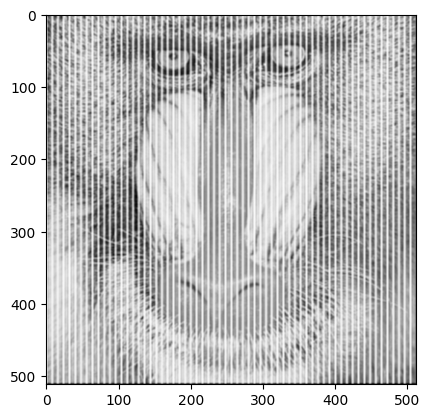

In [76]:
for i in range(1, M2-1):
    for j in range(1, N2-1):
        window = [
            impulse_img2[i-1, j-1],   impulse_img2[i, j-1],     impulse_img2[i+1, j-1],
            impulse_img2[i-1, j],     impulse_img2[i, j],       impulse_img2[i+1, j],
            impulse_img2[i-1, j+1],   impulse_img2[i, j+1],     impulse_img2[i+1, j+1],
        ]
        
        # impulse_img3[i, j] = np.median(window)
        impulse_img3[i, j] = np.mean(window)

clean_img = impulse_img3[1:M2-1, 1:N2-1]

plt.imshow(clean_img, cmap='gray')

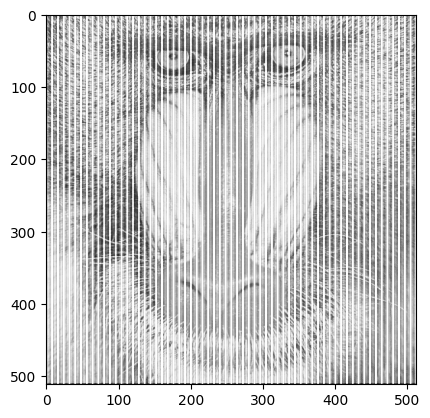

In [75]:
plt.imshow(hf_img, cmap='gray')

Поймем, что выходит не очень. И будем использовать другой способ

Для начала посмотрим двух-мерный Фурье-спектр

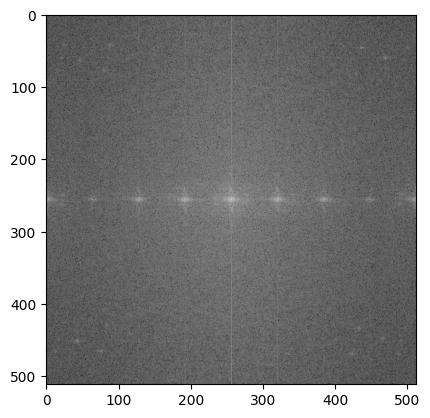

In [85]:
M, N = hf_img.shape

fft2 = np.fft.fft2(hf_img)
ft = np.fft.fftshift(fft2)

plt.imshow(np.log(np.abs(ft)), cmap='gray')

Видим те части, которые нам нужно отфильтровать

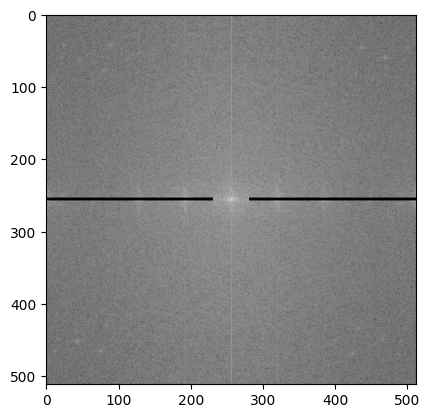

In [86]:
N2 = int(N/2)
M2 = int(M/2)

ft[M2 - 2: M2 + 2, :N2 - 25] = 1
ft[M2 - 2: M2 + 2, N2 + 25:] = 1

plt.imshow(np.log(np.abs(ft)), cmap='gray')

После того, как мы отфильтровали нужные области, возвращаем изображению нормальный вид

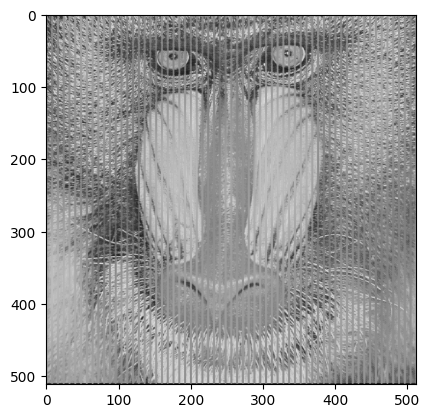

In [87]:
restored_img = abs(np.fft.ifft2(ft))

plt.imshow(restored_img, cmap='gray')

## Другие операции с изображениями

Необходима библиотека scikit-image

In [88]:
from skimage.exposure import rescale_intensity

In [93]:
def convolve(image, kernel):
	# считываем размеры изображения и ядра свертки
	(iH, iW) = image.shape[:2]
	(kH, kW) = kernel.shape[:2]
	# делаем паддинг для изображения
	pad = (kW - 1) // 2
	image = cv2.copyMakeBorder(image, pad, pad, pad, pad,
		cv2.BORDER_REPLICATE)
    # создаем пустое изображение, в которое будем записывать результат
	output = np.zeros((iH, iW), dtype="float32")
    # итерируемся по x и y
	for y in np.arange(pad, iH + pad):
		for x in np.arange(pad, iW + pad):
			# выхватываем окно
			roi = image[y - pad:y + pad + 1, x - pad:x + pad + 1]
			# и сворачиваем его с ядром
			k = (roi * kernel).sum()
			output[y - pad, x - pad] = k
    # rescale the output image to be in the range [0, 255]
	output = rescale_intensity(output, in_range=(0, 255))
	output = (output * 255).astype("uint8")
	# return the output image
	return output

In [94]:
# шарпенинг (повышение резкости)
sharpen = np.array((
	[0, -1, 0],
	[-1, 5, -1],
	[0, -1, 0]), dtype="int")

# выделение границ
laplacian = np.array((
	[0, 1, 0],
	[1, -4, 1],
	[0, 1, 0]), dtype="int")

sobelX = np.array((
	[-1, 0, 1],
	[-2, 0, 2],
	[-1, 0, 1]), dtype="int")

sobelY = np.array((
	[-1, -2, -1],
	[0, 0, 0],
	[1, 2, 1]), dtype="int")

prewittX = np.array((
	[-1, 0, 1],
	[-1, 0, 1],
	[-1, 0, 1]), dtype="int")

prewittY = np.array((
	[-1, -1, -1],
	[0, 0, 0],
	[1, 1, 1]), dtype="int")

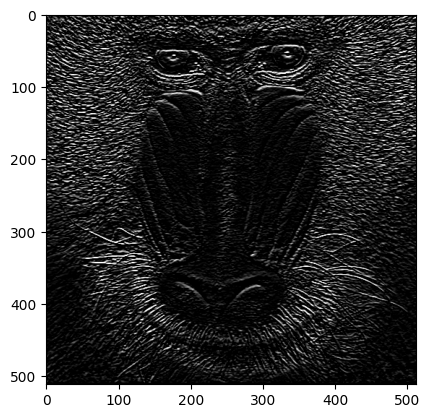

In [100]:
result = convolve(img, prewittY)

plt.imshow(result, cmap='gray')

Эквализация гистограммы

$ 255 * \left( \frac{I - I_{min}}{I_{max}-I_{min}} \right) $

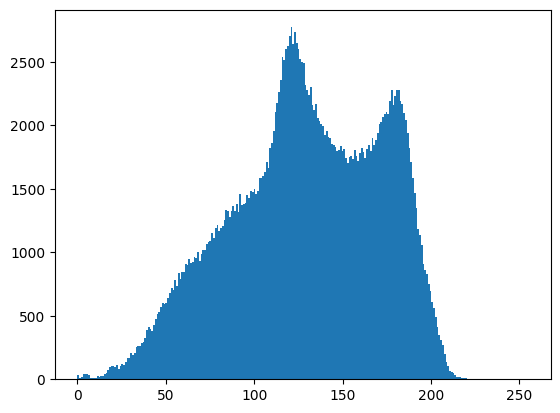

In [101]:
plt.hist(img.ravel(), 256, [0, 255])
plt.show()

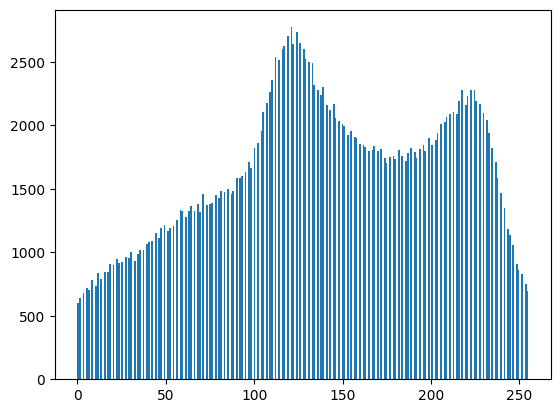

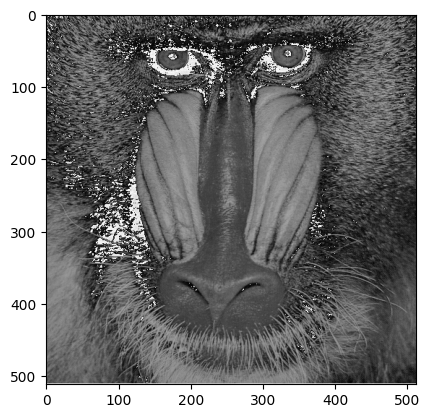

In [106]:
Imin = 50
Imax = 200

img_eq = 255 * ((img - Imin)/(Imax - Imin))

plt.hist(img_eq.ravel(), 256, [0, 255])
plt.show()

plt.imshow(img_eq, cmap='gray')

Гамма-коррекция

$ \left( \Big(\frac{I}{255}\Big)^{\frac{1}{\gamma}} \right)*255 $

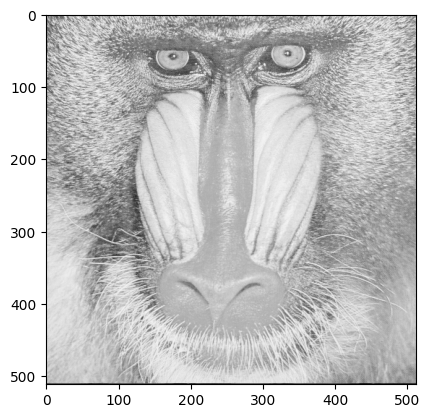

In [110]:
gamma = 1.9
invGamma = 1 / gamma

table = [((i / 255) ** invGamma) * 255 for i in range(256)]
table = np.array(table, np.uint8)

img_c = cv2.LUT(img, table)

plt.imshow(img_c, cmap='gray')

Бинаризация

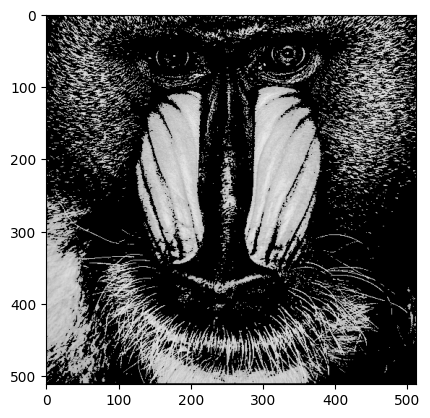

In [112]:
thr = 150
img_bin = (img > thr) * img

plt.imshow(img_bin, cmap='gray')